###### Importing all required libraries:

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print('Libraries imported.')

Libraries imported.


###### Foursquare Credentials and Version

In [2]:
CLIENT_ID = 'R1OZOCPX1S5NGN35CRGKLJF2A4VTU0ZUPUQFCMXGICDT4MSX'
CLIENT_SECRET = 'GKHV4NK2LZ0EBHECMELHGMJYL3AEF2FNJWTN0CIIOCJ4PSCA'
VERSION = '20180604'

###### Define Functions for Use Later

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

###### Get Initial NYC Data

In [4]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
ny_data.shape

(306, 4)

Therefore, New York has a total of 306 different neighborhoods.

###### Initial Data Analysis

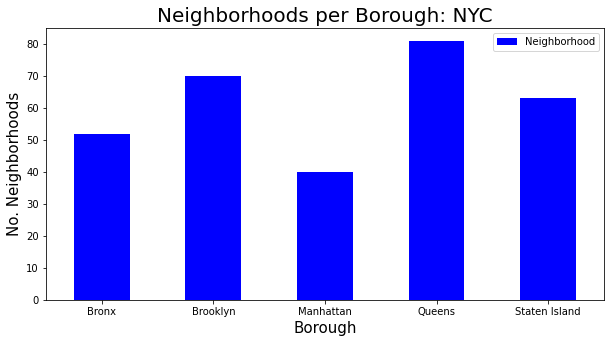

In [7]:
clr = "blue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

###### Analyse further and see how many Japanese restaurants there are in each neighborhood and borough. After it, graph the results

In [8]:
# queens has most neighborhoods
# prepare neighborhood list that contains japanese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_restaurants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(ny_data),')','Japanese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(japanese_restaurants)))
    print(row)
    for resturant_detail in japanese_restaurants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Japanese Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Japanese Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Japanese Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Japanese Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Japanese Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Japanese Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Japanese Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Japanese Restaurants in Norwood, B

In [9]:
#japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv')

In [10]:
japanese_ny = pd.read_csv('japanese_rest_ny_tocsv1.csv')
japanese_rest_ny.tail()

,Borough,Neighborhood,ID,Name
60,Manhattan,Flatiron,4f7b61f6e4b07aaa5d524842,OOTOYA 大戸屋 (OOTOYA)
61,Manhattan,Flatiron,581a10901df6b32e66ec3a07,Sugarfish
62,Manhattan,Flatiron,55805bb5498e8356d675aa22,Yakiniku Futago
63,Queens,Sunnyside Gardens,4ba2a9cbf964a520d00d38e3,Oki Japanese Restaurant
64,Brooklyn,Fulton Ferry,5cf1562460255e002c5e683c,Bessou


In [11]:
japanese_rest_ny.shape

(65, 4)

There are 65 Japanese Restaurants across New York City. Manhattan had the least number of neighborhoods, it does have the highest number of Japanese restaurants. Additionally, it is possible to see how many restaurants the top 6 neighborhoods have. The neighborhood of Murray Hill has the highest number of Japanese restaurants in all of NYC and is actually located in the boroughs of Manhattan and Queens.

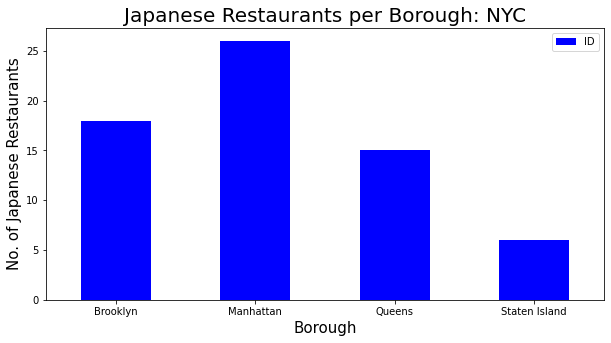

In [12]:
japanese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

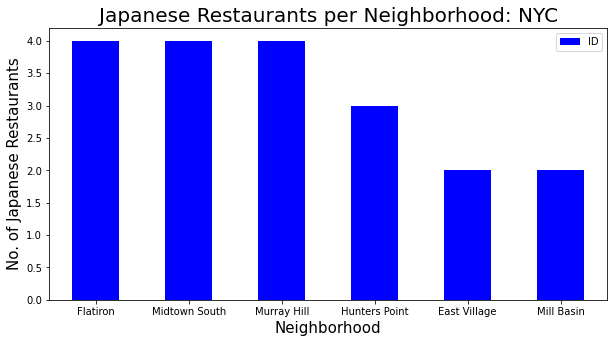

In [13]:
NOofNeigh = 6 # top number for graphing all the same past 6
japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [14]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,ID,Name
20,Manhattan,Murray Hill,4a99b4f4f964a520f62f20e3,Kajitsu
21,Manhattan,Murray Hill,559cbaa6498eaa4e8d884811,Tempura Matsui
22,Manhattan,Murray Hill,591caee89deb7d0f69be77a2,Omusubi Gonbei
37,Queens,Murray Hill,4bc8eee83740b713fcbe5d65,Northern Sushi


So Murray Hill, Midtown South and Flatrion in Manhattan all have the highest number of Japanese Restaurants with a total count of 4 each. Now we will get the ranking of each restaurant for further analysis.

In [17]:
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in japanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
# output not shown as it as VERY long

In [18]:
japanese_rest_stats_ny.to_csv('japanese_rest_stats_ny_csv.csv') # continue to save data to a .csv file

In [19]:
japanese_rest_stats_ny.shape

(65, 7)

Got statistics for all Japanese Restaurants in New York city. Let's check values in DataFrame.

In [20]:
# convert some values into floats for analysis
japanese_rest_stats_ny['Likes'] = japanese_rest_stats_ny['Likes'].astype('float64')
japanese_rest_stats_ny['Tips'] = japanese_rest_stats_ny['Tips'].astype('float64')
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       65 non-null     object 
 1   Neighborhood  65 non-null     object 
 2   ID            65 non-null     object 
 3   Name          65 non-null     object 
 4   Likes         65 non-null     float64
 5   Rating        65 non-null     float64
 6   Tips          65 non-null     float64
dtypes: float64(3), object(4)
memory usage: 3.7+ KB


In [21]:
japanese_rest_stats_ny.describe()

,Likes,Rating,Tips
count,65.0,6.500000e+01,65.0
mean,133.0,8.300000e+00,28.0
std,0.0,1.790181e-15,0.0
min,133.0,8.300000e+00,28.0
25%,133.0,8.300000e+00,28.0
50%,133.0,8.300000e+00,28.0
75%,133.0,8.300000e+00,28.0
max,133.0,8.300000e+00,28.0


In [22]:
# Resturant with maximum Likes
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood                  Kensington
ID              57ab615d498eef084faa348b
Name                         Abiko Curry
Likes                              133.0
Rating                               8.3
Tips                                28.0
Name: 0, dtype: object

In [23]:
# Resturant with maximum Ratings
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                  Kensington
ID              57ab615d498eef084faa348b
Name                         Abiko Curry
Likes                              133.0
Rating                               8.3
Tips                                28.0
Name: 0, dtype: object

In [24]:
# Resturant with maximum Tips
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood                  Kensington
ID              57ab615d498eef084faa348b
Name                         Abiko Curry
Likes                              133.0
Rating                               8.3
Tips                                28.0
Name: 0, dtype: object

###### Identify and visualise neighborhood with the maximum average rating of restaurants

In [25]:
ny_neighborhood_stats=japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
0,Bedford Stuyvesant,8.3
37,Prospect Heights,8.3
27,Little Neck,8.3
28,Lower East Side,8.3
29,Midtown,8.3
30,Midtown South,8.3
31,Mill Basin,8.3
32,Murray Hill,8.3
33,Noho,8.3
34,North Side,8.3


Above are the top neighborhoods with the highest average ratings of Japanese restaurants.

In [26]:
ny_borough_stats=japanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.3
0,Brooklyn,8.3
2,Queens,8.3
3,Staten Island,8.3


Similarly these are the average ratings of Japanese Restaurants for each Borough

###### Visualise the results

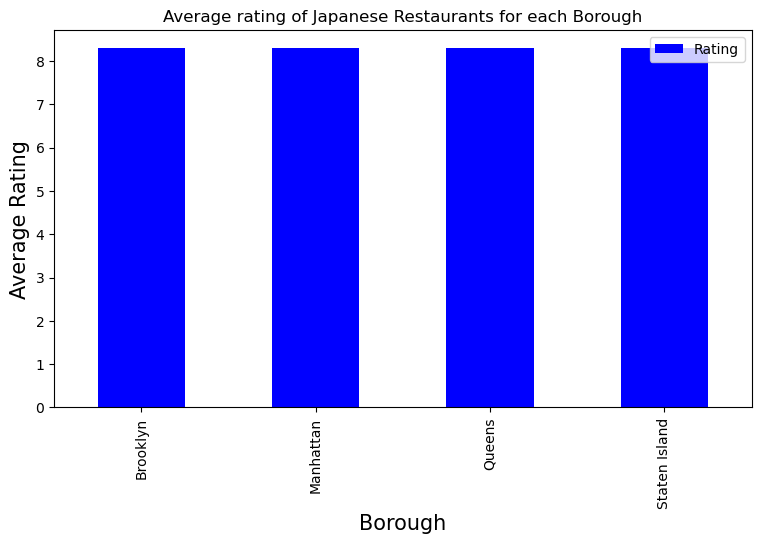

In [27]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Japanese Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
japanese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

Consider all the neighborhoods with average rating greater or equal 8.0 to visualize on a map

In [28]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]

ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [29]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [30]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)